In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
full_data = pd.read_csv('output.csv')
print(f"Number of rows: {full_data.shape[0]}")

Number of rows: 3585


In [3]:
# Drop duplicate rows
full_data = full_data.drop_duplicates()
print(f"Number of rows: {full_data.shape[0]}")
print(f"Number of columns: {full_data.shape[1]}")

Number of rows: 3549
Number of columns: 21


# Data Preprocessing

In [4]:
# Check for missing values
print(full_data.isnull().sum())

host_response_rate           0
host_identity_verified       0
host_total_listings_count    0
city                         0
is_location_exact            0
property_type                0
room_type                    0
accommodates                 0
bathrooms                    0
bedrooms                     0
beds                         0
bed_type                     0
amenities                    0
price                        0
minimum_nights               0
number_of_reviews            0
review_scores_rating         0
instant_bookable             0
cancellation_policy          0
reviews_per_month            0
fraud                        0
dtype: int64


There are no missing values

In [5]:
full_data.head()

,host_response_rate,host_identity_verified,host_total_listings_count,city,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,fraud
0,90,1,6,1,1,0,1,1,1.0,1.0,1.0,4,547,4000,7,34,90.0,0,2,0.38,0
1,100,1,7,2,1,8,1,2,1.0,1.0,1.0,4,1158,14500,3,36,91.0,0,2,0.40,0
2,100,1,7,2,1,0,0,4,1.0,1.0,2.0,4,2016,19500,3,47,95.0,0,2,0.54,1
3,100,1,1,2,1,0,1,2,1.0,1.0,1.0,4,964,6500,3,41,98.0,0,1,0.47,0
4,100,0,12,2,1,0,0,3,1.0,1.0,1.0,4,1794,15400,30,18,91.0,0,1,0.21,0


In [6]:
print(full_data.dtypes)

host_response_rate             int64
host_identity_verified         int64
host_total_listings_count      int64
city                           int64
is_location_exact              int64
property_type                  int64
room_type                      int64
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                       int64
amenities                      int64
price                          int64
minimum_nights                 int64
number_of_reviews              int64
review_scores_rating         float64
instant_bookable               int64
cancellation_policy            int64
reviews_per_month            float64
fraud                          int64
dtype: object


In [7]:
print("number of unique city values:")
print(full_data['city'].nunique())
print("number of unique property_type values:")
print(full_data['property_type'].nunique())
print("number of unique room_type values:")
print(full_data['room_type'].nunique())
print("number of unique bed_type values:")
print(full_data['bed_type'].nunique())
print("number of unique cancellation_policy values:")
print(full_data['cancellation_policy'].nunique())

number of unique city values:
38
number of unique property_type values:
13
number of unique room_type values:
3
number of unique bed_type values:
5
number of unique cancellation_policy values:
4


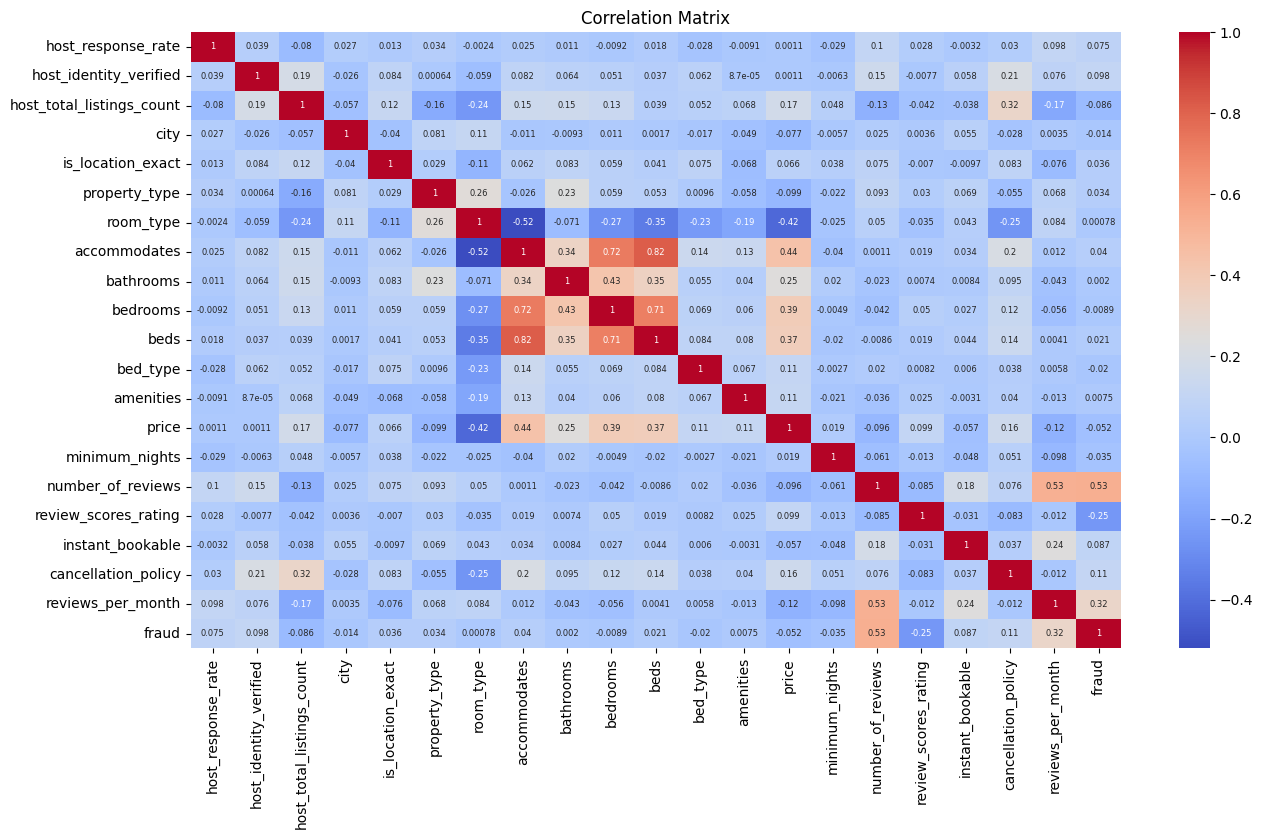

In [8]:
# correlation matrix
corr_matrix = full_data.corr()

plt.figure(figsize=(15, 8))  # Adjust width as needed

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 6})  # Adjust size as needed
plt.title('Correlation Matrix')
plt.show()

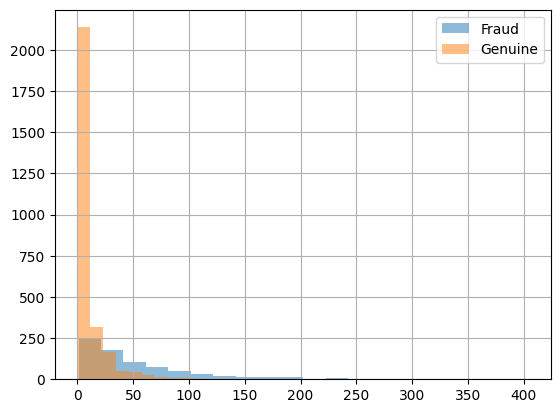

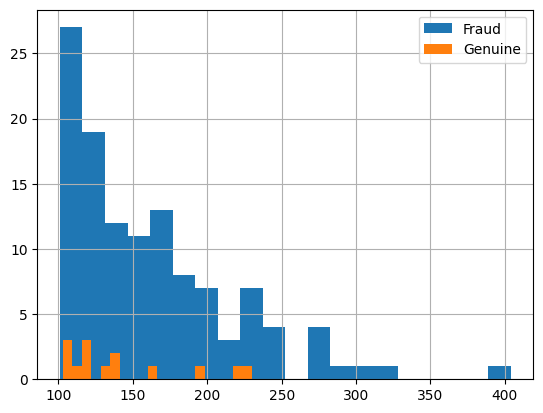

In [51]:
# histogram for distribution of number of reviews, split by fraud
# fraud reviews
fraud_reviews = full_data[full_data['fraud'] == 1]
fraud_reviews['number_of_reviews'].hist(bins=20, alpha=0.5, label='Fraud')

# genuine reviews
genuine_reviews = full_data[full_data['fraud'] == 0]
genuine_reviews['number_of_reviews'].hist(bins=20, alpha=0.5, label='Genuine')

plt.legend()
plt.show()

# filter to see distribution for more than 50 reviews and plot histogram
fraud_reviews[fraud_reviews['number_of_reviews'] > 100]['number_of_reviews'].hist(bins=20, label='Fraud')
genuine_reviews[genuine_reviews['number_of_reviews'] > 100]['number_of_reviews'].hist(bins=20, label='Genuine')
plt.legend()
plt.show()

In [9]:
full_data['city'] = full_data['city'].astype('category')
full_data = pd.get_dummies(full_data, columns=['city'], drop_first=True)

full_data['property_type'] = full_data['property_type'].astype('category')
full_data = pd.get_dummies(full_data, columns=['property_type'], drop_first=True)

full_data['room_type'] = full_data['room_type'].astype('category')
full_data = pd.get_dummies(full_data, columns=['room_type'], drop_first=True)

full_data['bed_type'] = full_data['bed_type'].astype('category')
full_data = pd.get_dummies(full_data, columns=['bed_type'], drop_first=True)

full_data['cancellation_policy'] = full_data['cancellation_policy'].astype('category')
full_data = pd.get_dummies(full_data, columns=['cancellation_policy'], drop_first=True)

print(full_data.head())

   host_response_rate  host_identity_verified  host_total_listings_count  \
0                  90                       1                          6   
1                 100                       1                          7   
2                 100                       1                          7   
3                 100                       1                          1   
4                 100                       0                         12   

   is_location_exact  accommodates  bathrooms  bedrooms  beds  amenities  \
0                  1             1        1.0       1.0   1.0        547   
1                  1             2        1.0       1.0   1.0       1158   
2                  1             4        1.0       1.0   2.0       2016   
3                  1             2        1.0       1.0   1.0        964   
4                  1             3        1.0       1.0   1.0       1794   

   price  minimum_nights  number_of_reviews  review_scores_rating  \
0   4000         

# Split train - test data

In [10]:
train_data, test_data = train_test_split(full_data, test_size=0.2, random_state=42)

# Exploratory Data Analysis

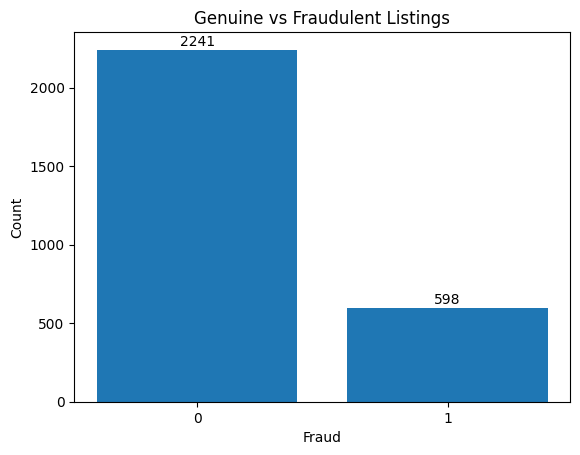

In [11]:
# Get the counts for each category
counts = train_data['fraud'].value_counts()

# Create the bar chart
plt.bar(counts.index, counts.values)

# Add labels to the bars
for i, v in enumerate(counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')  # Adjust position as needed

# Set the title and labels
plt.title("Genuine vs Fraudulent Listings")
plt.xlabel("Fraud")
plt.ylabel("Count")

# Set x-axis ticks to only 0 and 1
plt.xticks(counts.index)  # Use counts.index to ensure correct tick positions

# Show the plot
plt.show()

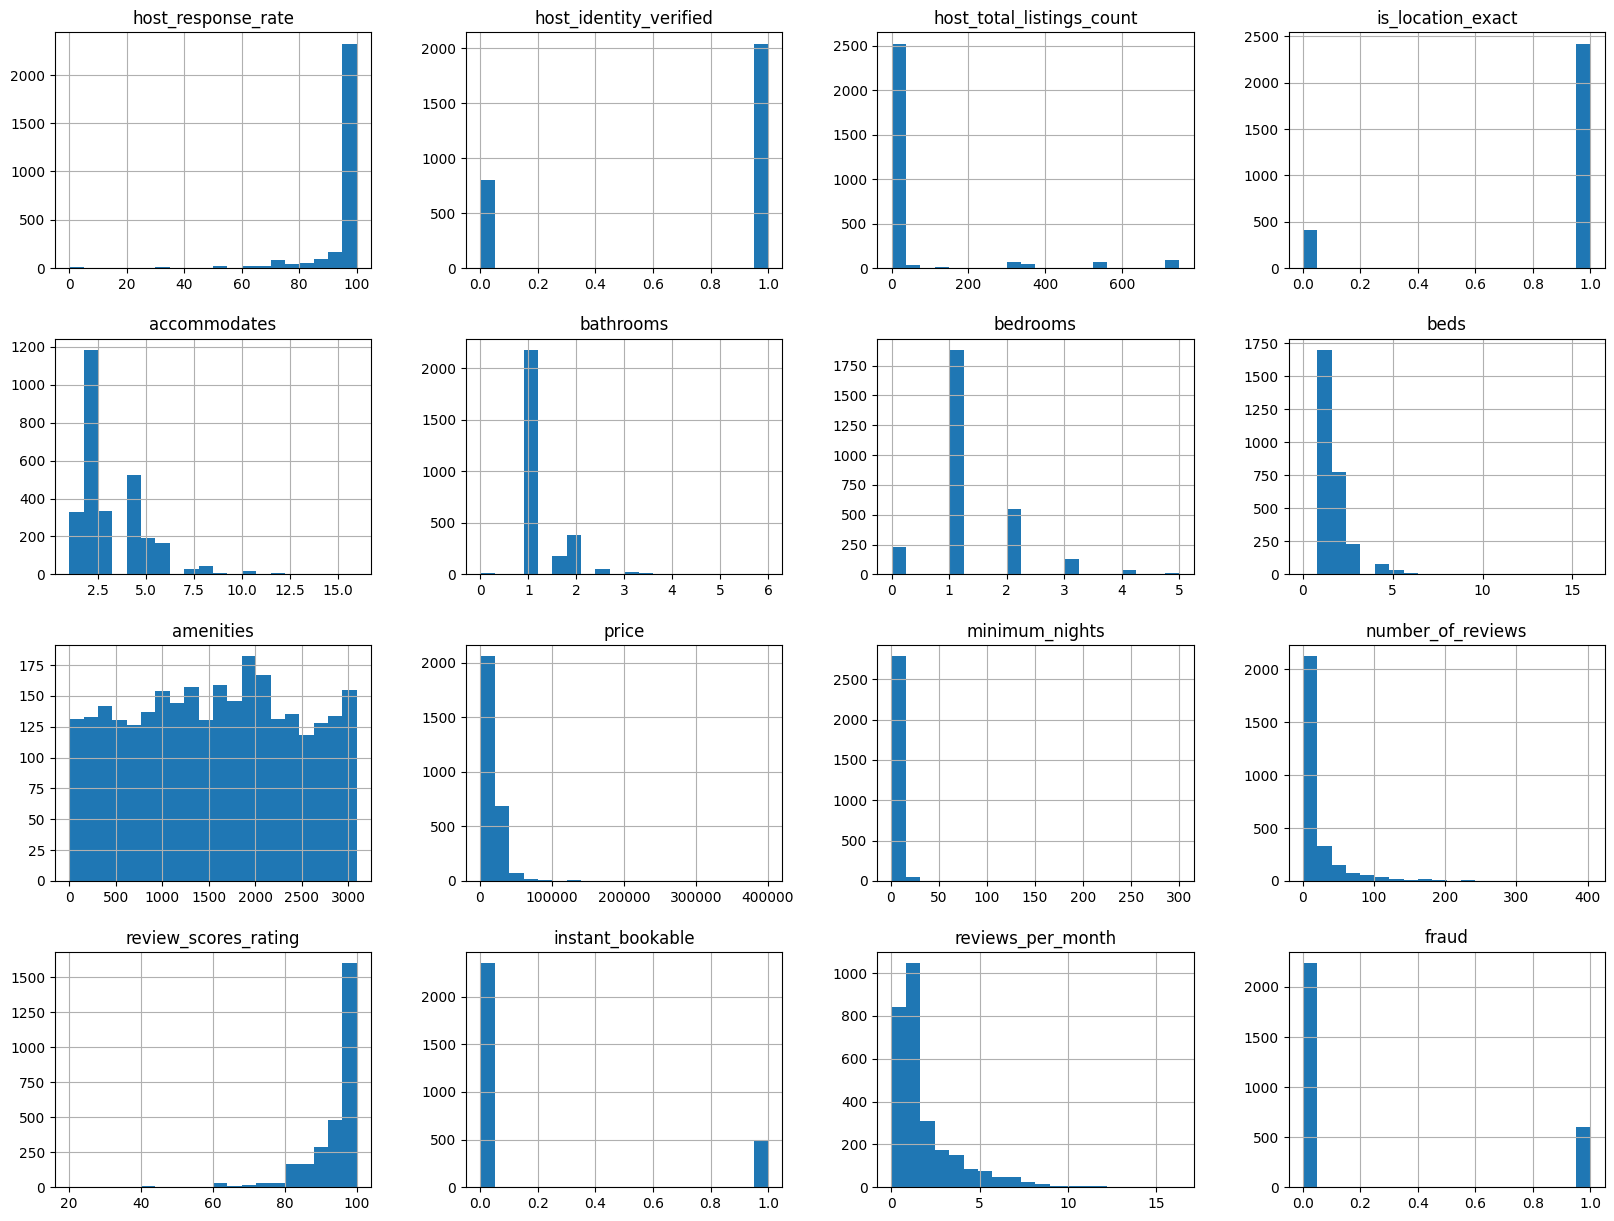

In [12]:
# Analyze distributions of key features
train_data.hist(bins=20, figsize=(20, 15))
plt.show()

# Feature Engineering

In [13]:
## Log Transformation for Skewed Numerical Data
train_data['log_price'] = np.log1p(train_data['price'])
test_data['log_price'] = np.log1p(test_data['price'])

train_data['log_reviews_per_month'] = np.log1p(train_data['reviews_per_month'])
test_data['log_reviews_per_month'] = np.log1p(test_data['reviews_per_month'])

train_data['log_host_total_listings_count'] = np.log1p(train_data['host_total_listings_count'])
test_data['log_host_total_listings_count'] = np.log1p(test_data['host_total_listings_count'])

## Interaction Features
train_data['price_per_occupant'] = train_data['log_price'] / (train_data['accommodates'] + 1)
test_data['price_per_occupant'] = test_data['log_price'] / (test_data['accommodates'] + 1)

train_data['bedroom_bathroom_ratio'] = train_data['bedrooms'] / (train_data['bathrooms'] + 1)
test_data['bedroom_bathroom_ratio'] = test_data['bedrooms'] / (test_data['bathrooms'] + 1)

# Drop Original Price
train_data = train_data.drop('price', axis=1)
test_data = test_data.drop('price', axis=1)
train_data = train_data.drop('reviews_per_month', axis=1)
test_data = test_data.drop('reviews_per_month', axis=1)
train_data = train_data.drop('host_total_listings_count', axis=1)
test_data = test_data.drop('host_total_listings_count', axis=1)

## Binning
train_data['review_bin'] = pd.cut(train_data['number_of_reviews'], bins=[0, 10, 50, 100, np.inf], labels=['low', 'medium', 'high', 'very high'])
train_data = pd.get_dummies(train_data, columns=['review_bin'], drop_first=True)

test_data['review_bin'] = pd.cut(test_data['number_of_reviews'], bins=[0, 10, 50, 100, np.inf], labels=['low', 'medium', 'high', 'very high'])
test_data = pd.get_dummies(test_data, columns=['review_bin'], drop_first=True)

train_data = train_data.drop('number_of_reviews', axis=1)
test_data = test_data.drop('number_of_reviews', axis=1)

In [14]:
numerical_cols = ['host_response_rate','log_host_total_listings_count','accommodates',
                  'bathrooms', 'bedrooms', 'beds',
                  'amenities', 'log_price', 'minimum_nights',
                  'review_scores_rating', 'log_reviews_per_month']

# Scale numerical columns
scaler = StandardScaler()
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

# Label encoding for binary variables
binary_cols = ['host_identity_verified', 'is_location_exact', 'instant_bookable']
for col in binary_cols:
    train_data[col] = LabelEncoder().fit_transform(train_data[col])
    test_data[col] = LabelEncoder().fit_transform(test_data[col])

# Split Data

In [15]:
# Define features (X) and target (y)
y = train_data['fraud']
X = train_data.drop('fraud', axis=1)

# Drop target column for test set (for use later)
y_test = test_data['fraud']
X_test = test_data.drop('fraud', axis=1, errors='ignore')

# Create SMOTE object
smote = SMOTE(random_state=42)

# Create StratifiedKFold split for cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

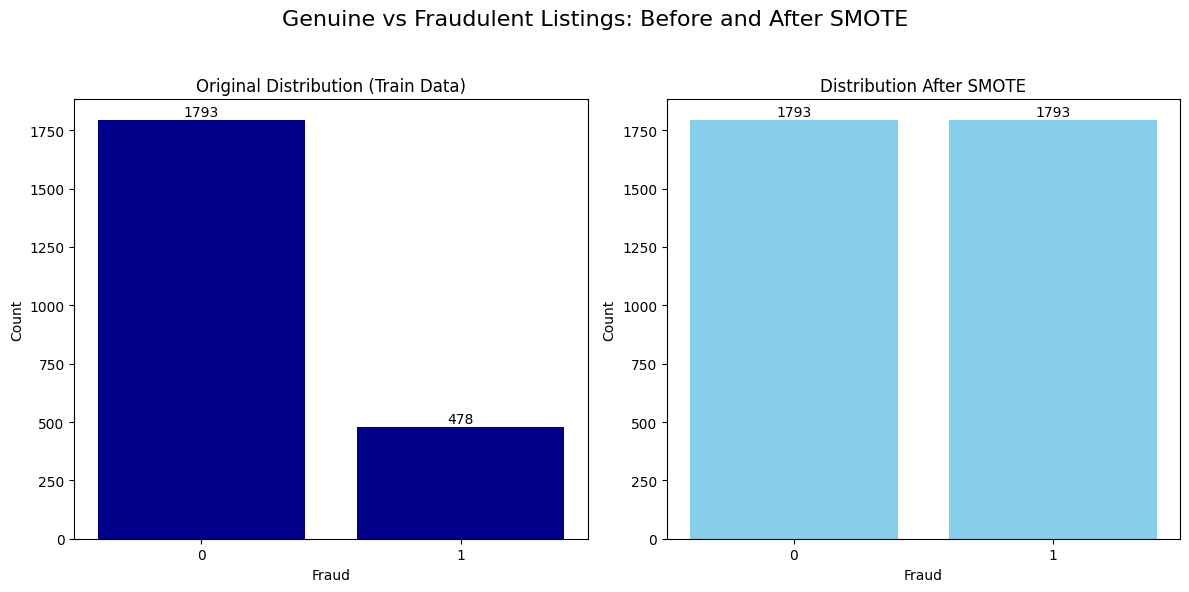

In [16]:
# Train-validation split
X_train_explore, X_val_explore, y_train_explore, y_val_explore = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_explore, y_train_explore)

# Get counts before and after SMOTE
counts_original = y_train_explore.value_counts()
counts_smote = y_resampled.value_counts()

# Create side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Original data distribution
axes[0].bar(counts_original.index, counts_original.values, color='darkblue')
axes[0].set_title("Original Distribution (Train Data)")
axes[0].set_xlabel("Fraud")
axes[0].set_ylabel("Count")
axes[0].set_xticks(counts_original.index)
for i, v in enumerate(counts_original.values):
    axes[0].text(i, v + 5, str(v), ha='center', va='bottom')

# SMOTE data distribution
axes[1].bar(counts_smote.index, counts_smote.values, color='skyblue')
axes[1].set_title("Distribution After SMOTE")
axes[1].set_xlabel("Fraud")
axes[1].set_ylabel("Count")
axes[1].set_xticks(counts_smote.index)
for i, v in enumerate(counts_smote.values):
    axes[1].text(i, v + 5, str(v), ha='center', va='bottom')

# Overall figure title
fig.suptitle("Genuine vs Fraudulent Listings: Before and After SMOTE", fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Models and Hyperparameter Tuning - Vanilla

## Logistic Regression


Cross-Validation with Best Logistic Regression Model...

Logistic Regression Cross-Validation ROC AUC Scores: [0.884243229585821, 0.875093005952381, 0.8656436011904763, 0.8790364583333333, 0.9038865546218487]
Mean ROC AUC Score for Logistic Regression: 0.881580569936772


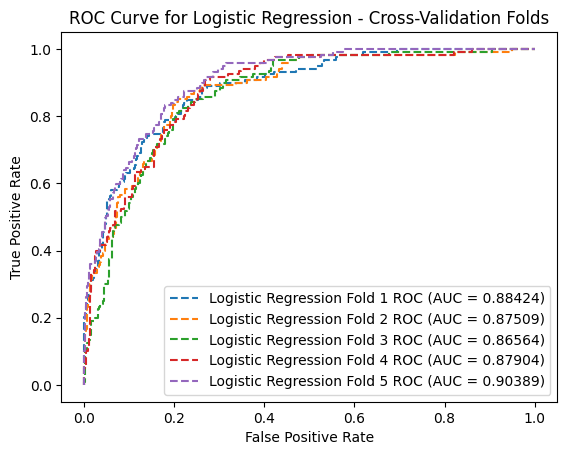

In [17]:
# Perform Stratified K-Fold Cross-Validation with the Logistic Regression model
print("\nCross-Validation with Best Logistic Regression Model...")

best_log_reg_clf = LogisticRegression(
    random_state=42,
    solver='saga',
    penalty='l1',
    max_iter=200,
    C=0.1
)

log_reg_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the best Logistic Regression model on this fold
    best_log_reg_clf.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_val_pred = best_log_reg_clf.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    log_reg_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'Logistic Regression Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nLogistic Regression Cross-Validation ROC AUC Scores: {log_reg_cv_roc_scores}')
print(f'Mean ROC AUC Score for Logistic Regression: {np.mean(log_reg_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## Random Forest Classifier

### Hyperparameter Tuning

In [19]:
def tune_rf_params():
    # Define Random Forest model with initial parameters
    rf_clf = RandomForestClassifier(
        random_state=42
    )

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    }

    # RandomizedSearchCV for Random Forest
    random_search_rf = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_grid,
        n_iter=50,
        scoring='f1',
        cv=skf,
        verbose=False,
        random_state=42,
        n_jobs=-1
    )

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_rf.fit(X, y)
    print("RandomizedSearchCV complete.")

    # Best parameters and best score
    best_rf_clf = random_search_rf.best_estimator_
    print(f"Best Parameters for Random Forest: {random_search_rf.best_params_}")
    print(f"Best F1 Score from RandomizedSearchCV: {random_search_rf.best_score_}")

# Uncomment to run
# tune_rf_params()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for Random Forest: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'bootstrap': False}
Best F1 Score from RandomizedSearchCV: 0.6009762582346684


Best Parameters for Random Forest: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 5, 'bootstrap': False}

Best F1 Score from RandomizedSearchCV: 0.6009762582346684

### Best Model


Cross-Validation with Best Random Forest Model...

Random Forest Cross-Validation ROC AUC Scores: [0.8907563025210085, 0.8759021577380952, 0.8708426339285714, 0.8917317708333332, 0.9031643907563025]
Mean ROC AUC Score for Random Forest: 0.8864794511554622


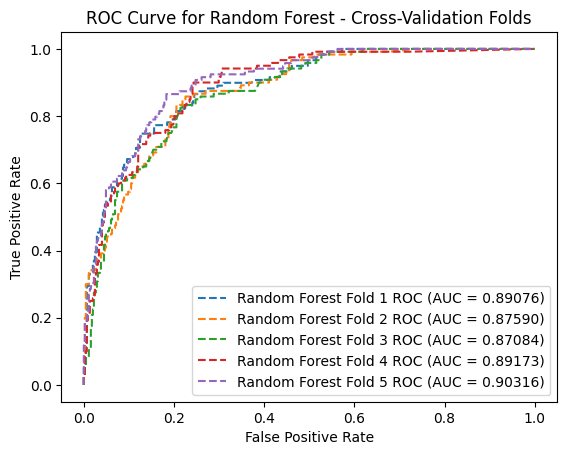

In [18]:
# Perform Stratified K-Fold Cross-Validation with the tuned Random Forest model
print("\nCross-Validation with Best Random Forest Model...")

best_rf_clf = RandomForestClassifier(
    random_state=42,
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features=None,
    max_depth=5,
    bootstrap=True
)

rf_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the best Random Forest model on this fold
    best_rf_clf.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_val_pred = best_rf_clf.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    rf_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'Random Forest Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nRandom Forest Cross-Validation ROC AUC Scores: {rf_cv_roc_scores}')
print(f'Mean ROC AUC Score for Random Forest: {np.mean(rf_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## Gradient Boosting Classifier

### Hyperparameter Tuning

In [21]:
def tune_gbc_params():
    # Define Gradient Boosting model with initial parameters
    gbc_clf = GradientBoostingClassifier(
        random_state=42
    )

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.6, 0.8, 1.0],
        'max_features': ['sqrt', 'log2', None]
    }

    # RandomizedSearchCV for Gradient Boosting
    random_search_gbc = RandomizedSearchCV(
        estimator=gbc_clf,
        param_distributions=param_grid,
        n_iter=50,
        scoring='f1',
        cv=skf,
        verbose=False,
        random_state=42,
        n_jobs=-1
    )

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_gbc.fit(X, y)
    print("RandomizedSearchCV complete.")

    # Best parameters and best score
    best_gbc_clf = random_search_gbc.best_estimator_
    print(f"Best Parameters for Gradient Boosting: {random_search_gbc.best_params_}")
    print(f"Best F1 Score from RandomizedSearchCV: {random_search_gbc.best_score_}")

# Uncomment to run
# tune_gbc_params()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for Gradient Boosting: {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.1}
Best F1 Score from RandomizedSearchCV: 0.579965738442289


Best Parameters for Gradient Boosting: {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 5, 'learning_rate': 0.1}

Best F1 Score from RandomizedSearchCV: 0.579965738442289

### Best Model


Cross-Validation with Best Gradient Boosting Model...

Gradient Boosting Cross-Validation ROC AUC Scores: [0.8692519323987946, 0.8485677083333334, 0.8700706845238095, 0.881361607142857, 0.8715298619447779]
Mean ROC AUC Score for Gradient Boosting: 0.8681563588687145


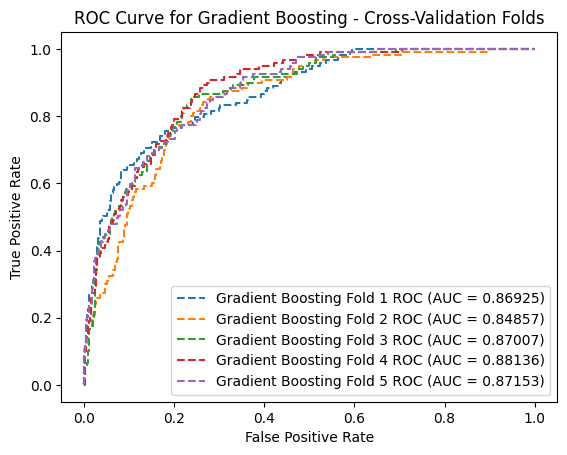

In [19]:
# Perform Stratified K-Fold Cross-Validation with the tuned Gradient Boosting model
print("\nCross-Validation with Best Gradient Boosting Model...")

best_gbc_clf = GradientBoostingClassifier(
    random_state=42,
    subsample=0.6,
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    max_depth=5,
    learning_rate=0.1
)

gbc_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the best Gradient Boosting model on this fold
    best_gbc_clf.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_val_pred = best_gbc_clf.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    gbc_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'Gradient Boosting Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nGradient Boosting Cross-Validation ROC AUC Scores: {gbc_cv_roc_scores}')
print(f'Mean ROC AUC Score for Gradient Boosting: {np.mean(gbc_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## LightGBM

### Hyperparameter Tuning

In [23]:
def tune_lgbm_params():
  # Define LightGBM model with initial parameters
  lgbm_model = LGBMClassifier(
      random_state=42,
      verbosity=-1
  )

  # Define the parameter grid for RandomizedSearchCV
  param_grid = {
      'n_estimators': [100, 200, 300, 400],
      'learning_rate': [0.01, 0.05, 0.1, 0.2],
      'max_depth': [3, 5, 7, 10],
      'num_leaves': [15, 31, 63, 127],
      'min_child_samples': [10, 20, 30],
      'subsample': [0.6, 0.8, 1.0],
      'colsample_bytree': [0.6, 0.8, 1.0]
  }

  # RandomizedSearchCV for LightGBM
  random_search_lgbm = RandomizedSearchCV(
      estimator=lgbm_model,
      param_distributions=param_grid,
      n_iter=50,
      scoring='f1',
      cv=skf,
      verbose=False,
      random_state=42,
      n_jobs=-1
  )

  # Fit RandomizedSearchCV
  print("Starting RandomizedSearchCV...")
  random_search_lgbm.fit(X, y)
  print("RandomizedSearchCV complete.")

  # Best parameters and best score
  best_lgbm_model = random_search_lgbm.best_estimator_
  print(f"Best Parameters for LightGBM: {random_search_lgbm.best_params_}")
  print(f"Best F1 Score from RandomizedSearchCV: {random_search_lgbm.best_score_}")

# uncomment to run
# tune_lgbm_params()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for LightGBM: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 30, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best F1 Score from RandomizedSearchCV: 0.5808492063492063


Best Parameters for LightGBM: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 30, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

Best F1 Score from RandomizedSearchCV: 0.5808492063492063

### Best Model


Cross-Validation with Best LightGBM Model...

LightGBM Cross-Validation ROC AUC Scores: [0.890644008160057, 0.8704613095238095, 0.8758928571428571, 0.8900669642857143, 0.8989720888355343]
Mean ROC AUC Score for LightGBM: 0.8852074455895945


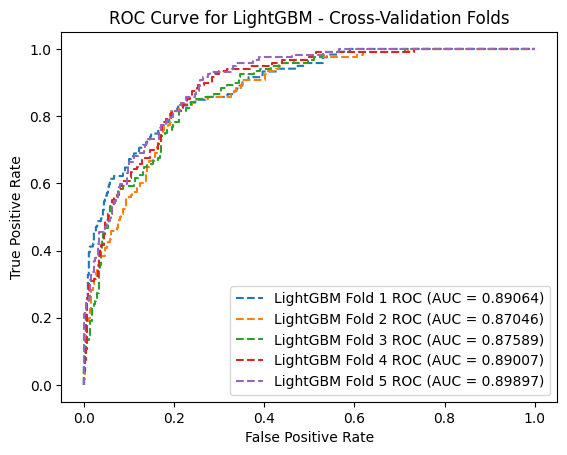

In [20]:
# Perform Stratified K-Fold Cross-Validation with the tuned LightGBM model
print("\nCross-Validation with Best LightGBM Model...")

best_lgbm_model = LGBMClassifier(
    random_state=42,
    verbosity=-1,
    subsample=0.8,
    num_leaves=31,
    n_estimators=100,
    min_child_samples=30,
    max_depth=3,
    learning_rate=0.1,
    colsample_bytree=0.8
)

lgbm_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the best LightGBM model on this fold
    best_lgbm_model.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_val_pred = best_lgbm_model.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    lgbm_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'LightGBM Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nLightGBM Cross-Validation ROC AUC Scores: {lgbm_cv_roc_scores}')
print(f'Mean ROC AUC Score for LightGBM: {np.mean(lgbm_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## XGBoost

### Hyperparameter Tuning

In [26]:
def tune_xgb_params():
    # Define XGBoost model with initial parameters
    xgb_model = XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        objective='binary:logistic',
        eval_metric='auc'
    )

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }

    # RandomizedSearchCV for XGBoost
    random_search_xgb = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=50,
        scoring='f1',
        cv=skf,
        verbose=False,
        random_state=42,
        n_jobs=-1
    )

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_xgb.fit(X, y)
    print("RandomizedSearchCV complete.")

    # Best parameters and best score
    best_xgb_model = random_search_xgb.best_estimator_
    print(f"Best Parameters for XGBoost: {random_search_xgb.best_params_}")
    print(f"Best F1 Score from RandomizedSearchCV: {random_search_xgb.best_score_}")

# Uncomment to run
# tune_xgb_params()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for XGBoost: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best F1 Score from RandomizedSearchCV: 0.5864461501264582


Best Parameters for XGBoost: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}

Best F1 Score from RandomizedSearchCV: 0.5864461501264582

### Best Model


Cross-Validation with Best XGBoost Model...

XGBoost Cross-Validation ROC AUC Scores: [0.8855346147367633, 0.8676897321428572, 0.876655505952381, 0.8873139880952381, 0.9024422268907564]
Mean ROC AUC Score for XGBoost: 0.8839272135635993


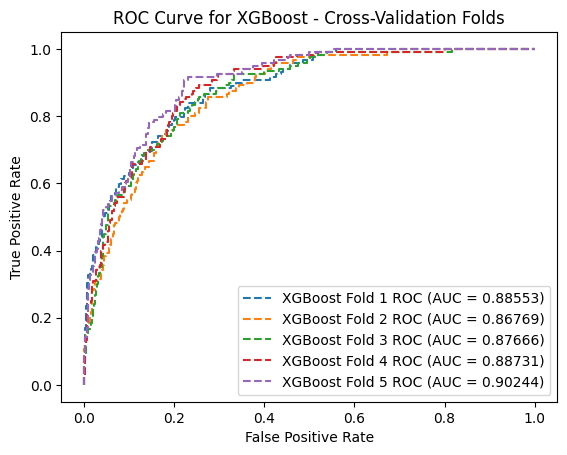

In [21]:
# Perform Stratified K-Fold Cross-Validation with the tuned XGBoost model
print("\nCross-Validation with Best XGBoost Model...")

best_xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='auc',
    subsample=0.6,
    reg_lambda=1.5,
    reg_alpha=0.1,
    n_estimators=200,
    min_child_weight=5,
    max_depth=3,
    learning_rate=0.05,
    gamma=0.1,
    colsample_bytree=0.8,
)

xgb_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the best XGBoost model on this fold
    best_xgb_model.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_val_pred = best_xgb_model.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    xgb_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'XGBoost Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nXGBoost Cross-Validation ROC AUC Scores: {xgb_cv_roc_scores}')
print(f'Mean ROC AUC Score for XGBoost: {np.mean(xgb_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## AdaBoost

### Hyperparameter Tuning

In [29]:
def tune_adaboost_params():
    # Define AdaBoost model with initial parameters
    adaboost_model = AdaBoostClassifier(
        random_state=42
    )

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200, 300, 400],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    }

    # RandomizedSearchCV for AdaBoost
    random_search_adaboost = RandomizedSearchCV(
        estimator=adaboost_model,
        param_distributions=param_grid,
        n_iter=20,
        scoring='roc_auc',
        cv=skf,
        verbose=False,
        random_state=42,
        n_jobs=-1
    )

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_adaboost.fit(X, y)
    print("RandomizedSearchCV complete.")

    # Best parameters and best score
    best_adaboost_model = random_search_adaboost.best_estimator_
    print(f"Best Parameters for AdaBoost: {random_search_adaboost.best_params_}")
    print(f"Best F1 Score from RandomizedSearchCV: {random_search_adaboost.best_score_}")

# Uncomment to run
# tune_adaboost_params()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for AdaBoost: {'n_estimators': 200, 'learning_rate': 0.05, 'algorithm': 'SAMME.R'}
Best F1 Score from RandomizedSearchCV: 0.8857486231895318


Best Parameters for AdaBoost: {'n_estimators': 200, 'learning_rate': 0.05, 'algorithm': 'SAMME.R'}

Best F1 Score from RandomizedSearchCV: 0.8857486231895318

### Best Model


Cross-Validation with Best AdaBoost Model...

AdaBoost Cross-Validation ROC AUC Scores: [0.8846736913028017, 0.8754650297619048, 0.8712518601190476, 0.8907180059523809, 0.9066345288115246]
Mean ROC AUC Score for AdaBoost: 0.8857486231895318


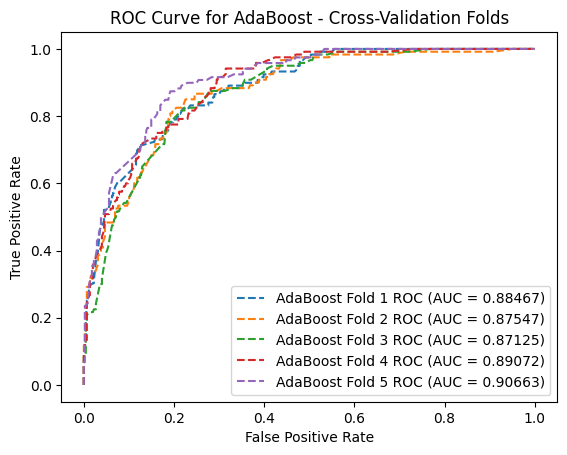

In [22]:
# Perform Stratified K-Fold Cross-Validation with the tuned AdaBoost model
print("\nCross-Validation with Best AdaBoost Model...")

best_adaboost_model = AdaBoostClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    algorithm='SAMME.R'
)

adaboost_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the best AdaBoost model on this fold
    best_adaboost_model.fit(X_train, y_train)

    # Predict probabilities for validation set
    y_val_pred = best_adaboost_model.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    adaboost_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'AdaBoost Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nAdaBoost Cross-Validation ROC AUC Scores: {adaboost_cv_roc_scores}')
print(f'Mean ROC AUC Score for AdaBoost: {np.mean(adaboost_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## Neural Network

### Model Training

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7211 - loss: 0.5770 - val_accuracy: 0.7911 - val_loss: 0.4473
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8056 - loss: 0.4243 - val_accuracy: 0.8028 - val_loss: 0.4029
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8224 - loss: 0.4051 - val_accuracy: 0.8122 - val_loss: 0.3805
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8189 - loss: 0.3817 - val_accuracy: 0.8216 - val_loss: 0.3707
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8462 - loss: 0.3475 - val_accuracy: 0.8251 - val_loss: 0.3694
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8455 - loss: 0.3320 - val_accuracy: 0.8228 - val_loss: 0.3604
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8427 - loss: 0.3386 - val_accuracy: 0.8228 - val_loss: 0.3587
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8482 - loss: 0.3258 - val_accuracy: 0.8263 - val_loss:

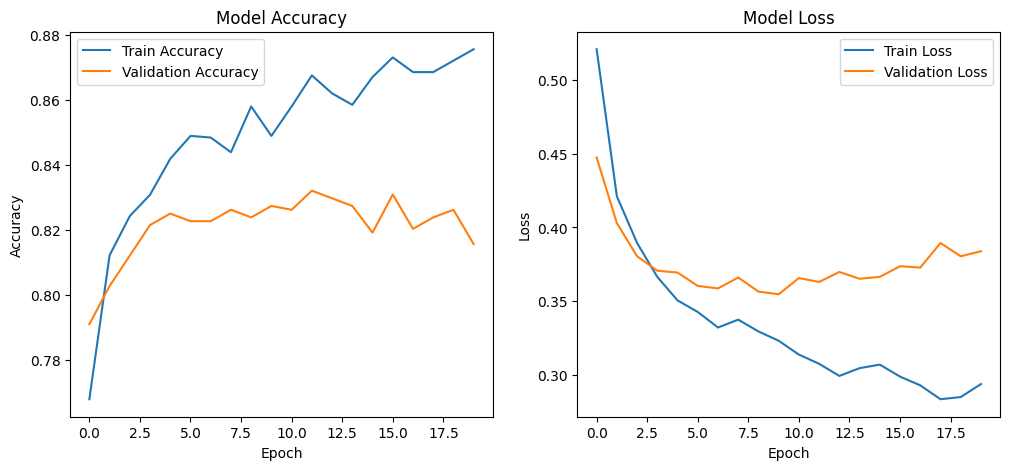

In [23]:
# Split data into training and validation sets (use stratified split for class balance)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build the neural network model
def build_nn_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
nn_model = build_nn_model()

# Train the model
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Can adjust based on performance
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on validation data
val_preds = nn_model.predict(X_val).flatten()
val_auc = roc_auc_score(y_val, val_preds)
print(f"Validation ROC-AUC Score: {val_auc:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediction - Vanilla

In [24]:
# Make predictions using Logistic Regression
y_test_pred_log_reg = best_log_reg_clf.predict(X_test)
y_test_pred_log_reg_proba = best_log_reg_clf.predict_proba(X_test)[:, 1]

# Make predictions using the best-tuned model (Random Forest)
y_test_pred_rf = best_rf_clf.predict(X_test)
y_test_pred_rf_proba = best_rf_clf.predict_proba(X_test)[:, 1]

# Make predictions using Gradient Boosting Classifier
y_test_pred_gbc = best_gbc_clf.predict(X_test)
y_test_pred_gbc_proba = best_gbc_clf.predict_proba(X_test)[:, 1]

# Make predictions using LightGBM model
y_test_pred_lgbm = best_lgbm_model.predict(X_test)
y_test_pred_lgbm_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

# Make predictions using XGBoost model
y_test_pred_xgb = best_xgb_model.predict(X_test)
y_test_pred_xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Make predictions using AdaBoost model
y_test_pred_adaboost = best_adaboost_model.predict(X_test)
y_test_pred_adaboost_proba = best_adaboost_model.predict_proba(X_test)[:, 1]

# Make predictions using Neural Network
y_test_pred_nn = nn_model.predict(X_test).flatten()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


# Evaluation - Vanilla


--- Logistic Regression ---
Logistic Regression ROC-AUC (Test Data): 0.9009942140896214
Confusion Matrix (Test Data - Logistic Regression):
[[523  18]
 [ 95  74]]
Classification Report (Test Data - Logistic Regression):
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       541
           1       0.80      0.44      0.57       169

    accuracy                           0.84       710
   macro avg       0.83      0.70      0.73       710
weighted avg       0.84      0.84      0.82       710


--- Tuned Random Forest ---
Tuned Random Forest ROC-AUC (Test Data): 0.9016067112185411
Confusion Matrix (Test Data - Tuned Random Forest):
[[524  17]
 [ 92  77]]
Classification Report (Test Data - Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       541
           1       0.82      0.46      0.59       169

    accuracy                           0.85       710
   macro avg 

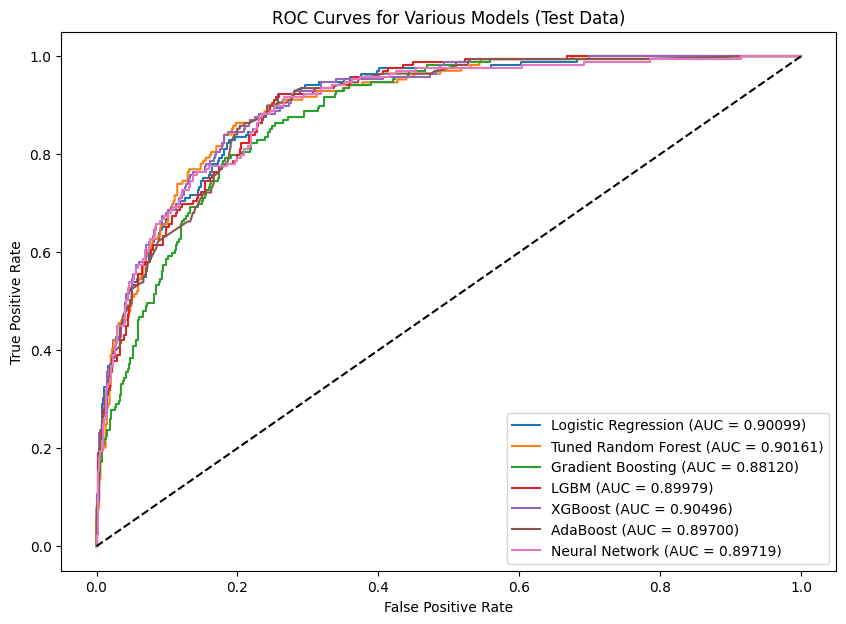

In [25]:
# 1. Logistic Regression Evaluation
print("\n--- Logistic Regression ---")
log_reg_roc_auc = roc_auc_score(y_test, y_test_pred_log_reg_proba)
print(f"Logistic Regression ROC-AUC (Test Data): {log_reg_roc_auc}")

print("Confusion Matrix (Test Data - Logistic Regression):")
print(confusion_matrix(y_test, y_test_pred_log_reg))

print("Classification Report (Test Data - Logistic Regression):")
print(classification_report(y_test, y_test_pred_log_reg))

# 2. Tuned Random Forest Evaluation
print("\n--- Tuned Random Forest ---")
rf_roc_auc = roc_auc_score(y_test, y_test_pred_rf_proba)  # y_test_pred_proba from best_rf model
print(f"Tuned Random Forest ROC-AUC (Test Data): {rf_roc_auc}")

print("Confusion Matrix (Test Data - Tuned Random Forest):")
print(confusion_matrix(y_test, y_test_pred_rf))

print("Classification Report (Test Data - Tuned Random Forest):")
print(classification_report(y_test, y_test_pred_rf))

# 3. Gradient Boosting Classifier Evaluation
print("\n--- Gradient Boosting Classifier ---")
gbc_roc_auc = roc_auc_score(y_test, y_test_pred_gbc_proba)
print(f"Gradient Boosting Classifier ROC-AUC (Test Data): {gbc_roc_auc}")

print("Confusion Matrix (Test Data - Gradient Boosting Classifier):")
print(confusion_matrix(y_test, y_test_pred_gbc))

print("Classification Report (Test Data - Gradient Boosting Classifier):")
print(classification_report(y_test, y_test_pred_gbc))

# 4. Light Gradient Boosting Machine Model Evaluation
print("\n--- LGBM Model ---")
lgbm_roc_auc = roc_auc_score(y_test, y_test_pred_lgbm_proba)
print(f"LGBM Model ROC-AUC (Test Data): {lgbm_roc_auc}")

print("Confusion Matrix (Test Data - LGBM Model):")
print(confusion_matrix(y_test, y_test_pred_lgbm))

print("Classification Report (Test Data - LGBM Model):")
print(classification_report(y_test, y_test_pred_lgbm))

# 5. eXtreme Gradient Boosting Model Evaluation
print("\n--- XGBoost Model ---")
xgb_roc_auc = roc_auc_score(y_test, y_test_pred_xgb_proba)
print(f"XGBoost Model ROC-AUC (Test Data): {xgb_roc_auc}")

print("Confusion Matrix (Test Data - XGBoost Model):")
print(confusion_matrix(y_test, y_test_pred_xgb))

print("Classification Report (Test Data - XGBoost):")
print(classification_report(y_test, y_test_pred_xgb))

# 6. Adaptive Boosting Model Evaluation
print("\n--- AdaBoost Model ---")
adaboost_roc_auc = roc_auc_score(y_test, y_test_pred_adaboost_proba)
print(f"AdaBoost Model ROC-AUC (Test Data): {adaboost_roc_auc}")

print("Confusion Matrix (Test Data - AdaBoost Model):")
print(confusion_matrix(y_test, y_test_pred_adaboost))

print("Classification Report (Test Data - AdaBoost):")
print(classification_report(y_test, y_test_pred_adaboost))

# 7. Neural Network Evaluation
print("\n--- Neural Network Model ---")
nn_roc_auc = roc_auc_score(y_test, y_test_pred_nn)
print(f"Neural Network ROC-AUC (Test Data): {nn_roc_auc}")

print("Confusion Matrix (Test Data - Neural Network Model):")
print(confusion_matrix(y_test, (y_test_pred_nn > 0.5).astype(int)))

print("Classification Report (Test Data - Neural Network):")
print(classification_report(y_test, (y_test_pred_nn > 0.5).astype(int)))

# Plot ROC Curves for all models
fpr_log, tpr_log, _ = roc_curve(y_test, y_test_pred_log_reg_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred_rf_proba)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_test_pred_gbc_proba)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_test_pred_lgbm_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_xgb_proba)
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test, y_test_pred_adaboost_proba)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_test_pred_nn)

plt.figure(figsize=(10, 7))

# Logistic Regression ROC curve
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {log_reg_roc_auc:.5f})')

# Tuned Random Forest ROC curve
plt.plot(fpr_rf, tpr_rf, label=f'Tuned Random Forest (AUC = {rf_roc_auc:.5f})')

# Gradient Boosting ROC curve
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {gbc_roc_auc:.5f})')

# LGBM ROC curve
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LGBM (AUC = {lgbm_roc_auc:.5f})')

# XGBoost ROC curve
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_roc_auc:.5f})')

# AdaBoost ROC curve
plt.plot(fpr_adaboost, tpr_adaboost, label=f'AdaBoost (AUC = {adaboost_roc_auc:.5f})')

# Neural Network ROC curve
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_roc_auc:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models (Test Data)')
plt.legend()
plt.show()

# Summary of Performance - Vanilla

In [26]:
evaluation_metrics = {
    "Model": ["Logistic Regression", "Tuned Random Forest", "Gradient Boosting", "LGBM", "XGBoost", "AdaBoost", "Neural Network"],
    "ROC-AUC": [
        round(roc_auc_score(y_test, y_test_pred_log_reg_proba), 3),
        round(roc_auc_score(y_test, y_test_pred_rf_proba), 3),
        round(roc_auc_score(y_test, y_test_pred_gbc_proba), 3),
        round(roc_auc_score(y_test, y_test_pred_lgbm_proba), 3),
        round(roc_auc_score(y_test, y_test_pred_xgb_proba), 3),
        round(roc_auc_score(y_test, y_test_pred_adaboost_proba), 3),
        round(roc_auc_score(y_test, y_test_pred_nn), 3)
    ],
    "Accuracy (%)": [
        round(accuracy_score(y_test, y_test_pred_log_reg) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_rf) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_gbc) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_lgbm) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_xgb) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_adaboost) * 100, 3),
        round(accuracy_score(y_test, (y_test_pred_nn > 0.5).astype(int)) * 100, 3)
    ],
    "Precision (%)": [
        round(precision_score(y_test, y_test_pred_log_reg) * 100, 3),
        round(precision_score(y_test, y_test_pred_rf) * 100, 3),
        round(precision_score(y_test, y_test_pred_gbc) * 100, 3),
        round(precision_score(y_test, y_test_pred_lgbm) * 100, 3),
        round(precision_score(y_test, y_test_pred_xgb) * 100, 3),
        round(precision_score(y_test, y_test_pred_adaboost) * 100, 3),
        round(precision_score(y_test, (y_test_pred_nn > 0.5).astype(int)) * 100, 3)
    ],
    "Recall (%)": [
        round(recall_score(y_test, y_test_pred_log_reg) * 100, 3),
        round(recall_score(y_test, y_test_pred_rf) * 100, 3),
        round(recall_score(y_test, y_test_pred_gbc) * 100, 3),
        round(recall_score(y_test, y_test_pred_lgbm) * 100, 3),
        round(recall_score(y_test, y_test_pred_xgb) * 100, 3),
        round(recall_score(y_test, y_test_pred_adaboost) * 100, 3),
        round(recall_score(y_test, (y_test_pred_nn > 0.5).astype(int)) * 100, 3)
    ],
    "F1 Score": [
        round(f1_score(y_test, y_test_pred_log_reg), 3),
        round(f1_score(y_test, y_test_pred_rf), 3),
        round(f1_score(y_test, y_test_pred_gbc), 3),
        round(f1_score(y_test, y_test_pred_lgbm), 3),
        round(f1_score(y_test, y_test_pred_xgb), 3),
        round(f1_score(y_test, y_test_pred_adaboost), 3),
        round(f1_score(y_test, (y_test_pred_nn > 0.5).astype(int)), 3)
    ]
}

# Convert to DataFrame for easy viewing
metrics_df = pd.DataFrame(evaluation_metrics)

# Convert DataFrame to tabulate format
print(tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False))


+---------------------+---------+--------------+---------------+------------+----------+
|        Model        | ROC-AUC | Accuracy (%) | Precision (%) | Recall (%) | F1 Score |
+---------------------+---------+--------------+---------------+------------+----------+
| Logistic Regression |  0.901  |    84.085    |    80.435     |   43.787   |  0.567   |
| Tuned Random Forest |  0.902  |    84.648    |    81.915     |   45.562   |  0.586   |
|  Gradient Boosting  |  0.881  |    82.535    |    68.293     |   49.704   |  0.575   |
|        LGBM         |   0.9   |    84.225    |    76.147     |   49.112   |  0.597   |
|       XGBoost       |  0.905  |    84.789    |    78.505     |   49.704   |  0.609   |
|      AdaBoost       |  0.897  |    83.662    |    83.544     |   39.053   |  0.532   |
|   Neural Network    |  0.897  |    83.944    |    82.353     |   41.42    |  0.551   |
+---------------------+---------+--------------+---------------+------------+----------+


# Models and Hyperparameter Tuning - SMOTE

## Logistic Regression


Cross-Validation with Best Logistic Regression Model...

Logistic Regression Cross-Validation ROC AUC Scores: [0.8775242836555558, 0.8695126488095238, 0.8643043154761905, 0.8753720238095238, 0.8793142256902762]
Mean ROC AUC Score for Logistic Regression: 0.8732054994882141


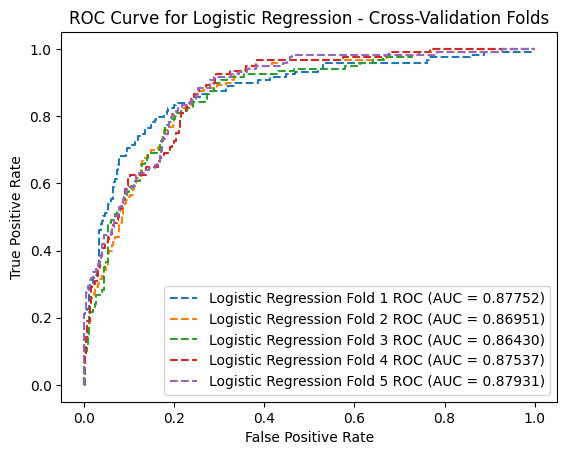

In [34]:
# Perform Stratified K-Fold Cross-Validation with the tuned Logistic Regression model
print("\nCross-Validation with Best Logistic Regression Model...")

best_log_reg_clf_smote = LogisticRegression(
    random_state=42,
    solver='saga',
    penalty='l1',
    class_weight=None,
    max_iter=200,
    C=0.1
)

log_reg_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Fit the best Logistic Regression model on this fold
    best_log_reg_clf_smote.fit(X_train_smote, y_train_smote)

    # Predict probabilities for validation set
    y_val_pred = best_log_reg_clf_smote.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    log_reg_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'Logistic Regression Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nLogistic Regression Cross-Validation ROC AUC Scores: {log_reg_cv_roc_scores}')
print(f'Mean ROC AUC Score for Logistic Regression: {np.mean(log_reg_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## Random Forest Classifier

### Hyperparameter Tuning

In [45]:
def tune_rf_params_smote():
    # Define Random Forest model with initial parameters
    rf_clf = RandomForestClassifier(
        random_state=42
    )

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'clf__n_estimators': [100, 200, 300, 400],
        'clf__max_depth': [3, 5, 7, 10, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__max_features': ['sqrt', 'log2', None],
        'clf__bootstrap': [True, False]
    }

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),  # Apply SMOTE on training data
        ('clf', rf_clf)
    ])

    # RandomizedSearchCV for Random Forest
    random_search_rf = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=50,  # Number of random combinations to try
        scoring='roc_auc',
        cv=skf,
        verbose=False,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_rf.fit(X, y)
    print("RandomizedSearchCV complete.")

    # Best parameters and best score
    best_rf_clf = random_search_rf.best_estimator_
    print(f"Best Parameters for Random Forest: {random_search_rf.best_params_}")
    print(f"Best ROC-AUC Score from RandomizedSearchCV: {random_search_rf.best_score_}")

# Uncomment to run
# tune_rf_params_smote()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for Random Forest: {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': None, 'clf__max_depth': 7, 'clf__bootstrap': True}
Best ROC-AUC Score from RandomizedSearchCV: 0.8829044416694851


Best Parameters for Random Forest: {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': None, 'clf__max_depth': 7, 'clf__bootstrap': True}

Best ROC-AUC Score from RandomizedSearchCV: 0.8829044416694851

### Best Model


Cross-Validation with Best Random Forest Model...

Random Forest Cross-Validation ROC AUC Scores: [0.8868727892047688, 0.8722656249999999, 0.8794270833333333, 0.8832496279761906, 0.8927070828331332]
Mean ROC AUC Score for Random Forest: 0.8829044416694851


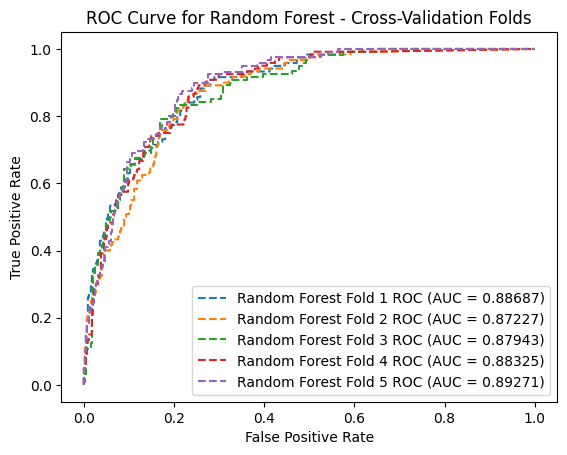

In [27]:
# Perform Stratified K-Fold Cross-Validation with the tuned Random Forest model
print("\nCross-Validation with Best Random Forest Model...")

best_rf_clf_smote = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features=None,
    max_depth=7,
    bootstrap=True
)

rf_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Fit the best Random Forest model on this fold
    best_rf_clf_smote.fit(X_train_smote, y_train_smote)

    # Predict probabilities for validation set
    y_val_pred = best_rf_clf_smote.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    rf_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'Random Forest Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nRandom Forest Cross-Validation ROC AUC Scores: {rf_cv_roc_scores}')
print(f'Mean ROC AUC Score for Random Forest: {np.mean(rf_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## Gradient Boosting Classifier

### Hyperparameter Tuning

In [48]:
def tune_gbc_params_smote():
    # Define Gradient Boosting model with initial parameters
    gbc_clf = GradientBoostingClassifier(
        random_state=42
    )

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'clf__n_estimators': [100, 200, 300, 400],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__max_features': ['sqrt', 'log2', None]
    }

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),  # Apply SMOTE on training data
        ('clf', gbc_clf)
    ])

    # RandomizedSearchCV for Gradient Boosting
    random_search_gbc = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=50,  # Number of random combinations to try
        scoring='roc_auc',
        cv=skf,
        verbose=False,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_gbc.fit(X, y)
    print("RandomizedSearchCV complete.")

    # Best parameters and best score
    best_gbc_clf = random_search_gbc.best_estimator_
    print(f"Best Parameters for Gradient Boosting: {random_search_gbc.best_params_}")
    print(f"Best ROC-AUC Score from RandomizedSearchCV: {random_search_gbc.best_score_}")

# Uncomment to run
# tune_gbc_params_smote()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for Gradient Boosting: {'clf__subsample': 0.6, 'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': None, 'clf__max_depth': 5, 'clf__learning_rate': 0.01}
Best ROC-AUC Score from RandomizedSearchCV: 0.884462298282342


Best Parameters for Gradient Boosting: {'clf__subsample': 0.6, 'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': None, 'clf__max_depth': 5, 'clf__learning_rate': 0.01}

Best ROC-AUC Score from RandomizedSearchCV: 0.884462298282342

### Best Model


Cross-Validation with Best Gradient Boosting Model...

Gradient Boosting Cross-Validation ROC AUC Scores: [0.8918043832232225, 0.8631882440476191, 0.8794270833333333, 0.8894903273809524, 0.8869297719087635]
Mean ROC AUC Score for Gradient Boosting: 0.8821679619787781


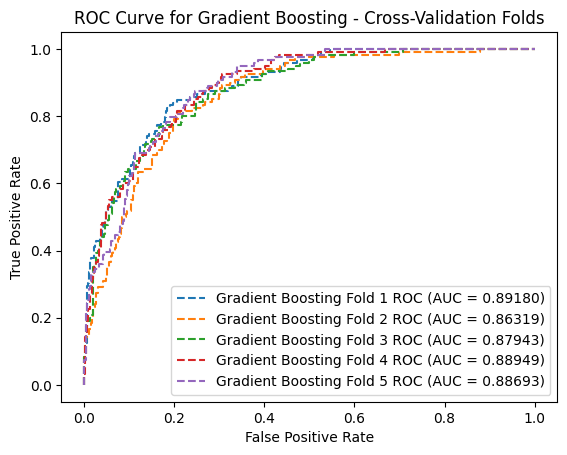

In [28]:
# Perform Stratified K-Fold Cross-Validation with the tuned Gradient Boosting model
print("\nCross-Validation with Best Gradient Boosting Model...")

best_gbc_clf_smote = GradientBoostingClassifier(
    random_state=42,
    subsample=0.8,
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features=None,
    max_depth=3,
    learning_rate=0.05
)

gbc_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Fit the best Gradient Boosting model on this fold
    best_gbc_clf_smote.fit(X_train_smote, y_train_smote)

    # Predict probabilities for validation set
    y_val_pred = best_gbc_clf_smote.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    gbc_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'Gradient Boosting Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nGradient Boosting Cross-Validation ROC AUC Scores: {gbc_cv_roc_scores}')
print(f'Mean ROC AUC Score for Gradient Boosting: {np.mean(gbc_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## LightGBM

### Hyperparameter Tuning

In [50]:
def tune_lgbm_params_smote():
  # Define LightGBM model with initial parameters
  lgbm_model = LGBMClassifier(
      random_state=42,
      verbosity=-1
  )

  # Define the parameter grid for RandomizedSearchCV
  param_grid = {
      'clf__n_estimators': [100, 200, 300, 400],
      'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
      'clf__max_depth': [3, 5, 7, 10],
      'clf__num_leaves': [15, 31, 63, 127],
      'clf__min_child_samples': [10, 20, 30],
      'clf__subsample': [0.6, 0.8, 1.0],
      'clf__colsample_bytree': [0.6, 0.8, 1.0]
  }

  pipeline = ImbPipeline([
      ('smote', SMOTE(random_state=42)),  # Apply SMOTE on training data
      ('clf', lgbm_model)
  ])

  # RandomizedSearchCV for LightGBM
  random_search_lgbm = RandomizedSearchCV(
      estimator=pipeline,
      param_distributions=param_grid,
      n_iter=50,  # Number of random combinations to try
      scoring='roc_auc',
      cv=skf,
      verbose=False,
      random_state=42,
      n_jobs=-1  # Use all available cores
  )

  # Fit RandomizedSearchCV
  print("Starting RandomizedSearchCV...")
  random_search_lgbm.fit(X, y)
  print("RandomizedSearchCV complete.")

  # Best parameters and best score
  best_lgbm_model = random_search_lgbm.best_estimator_
  print(f"Best Parameters for LightGBM: {random_search_lgbm.best_params_}")
  print(f"Best ROC-AUC Score from RandomizedSearchCV: {random_search_lgbm.best_score_}")

# uncomment to run
# tune_lgbm_params_smote()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for LightGBM: {'clf__subsample': 1.0, 'clf__num_leaves': 15, 'clf__n_estimators': 200, 'clf__min_child_samples': 30, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8}
Best ROC-AUC Score from RandomizedSearchCV: 0.8891152798814403


Best Parameters for LightGBM: {'clf__subsample': 1.0, 'clf__num_leaves': 15, 'clf__n_estimators': 200, 'clf__min_child_samples': 30, 'clf__max_depth': 5, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8}

Best ROC-AUC Score from RandomizedSearchCV: 0.8891152798814403

### Best Model


Cross-Validation with Best LightGBM Model...

LightGBM Cross-Validation ROC AUC Scores: [0.8945181636128839, 0.8841331845238095, 0.8821056547619047, 0.8877418154761905, 0.897077581032413]
Mean ROC AUC Score for LightGBM: 0.8891152798814403


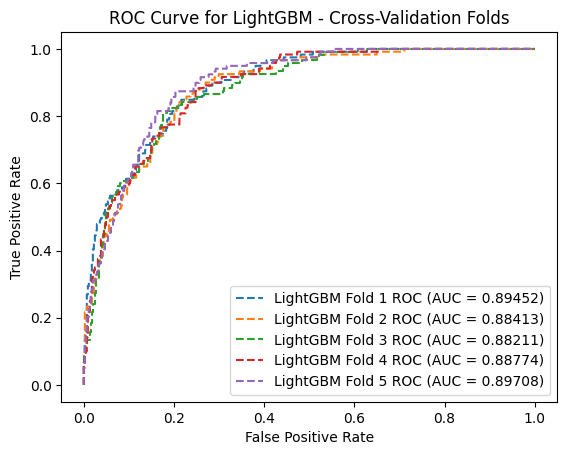

In [29]:
# Perform Stratified K-Fold Cross-Validation with the tuned LightGBM model
print("\nCross-Validation with Best LightGBM Model...")

best_lgbm_model_smote = LGBMClassifier(
    random_state=42,
    verbosity=-1,
    subsample=1,
    num_leaves=15,
    n_estimators=200,
    min_child_samples=30,
    max_depth=5,
    learning_rate=0.01,
    colsample_bytree=0.8
)

lgbm_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Fit the best LightGBM model on this fold
    best_lgbm_model_smote.fit(X_train_smote, y_train_smote)

    # Predict probabilities for validation set
    y_val_pred = best_lgbm_model_smote.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    lgbm_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'LightGBM Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nLightGBM Cross-Validation ROC AUC Scores: {lgbm_cv_roc_scores}')
print(f'Mean ROC AUC Score for LightGBM: {np.mean(lgbm_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## XGBoost

### Hyperparameter Tuning

In [56]:
def tune_xgb_params_smote():
    # Define XGBoost model with initial parameters
    xgb_model = XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        objective='binary:logistic',
        eval_metric='auc',
    )

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'clf__n_estimators': [100, 200, 300, 400],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__min_child_weight': [1, 3, 5],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0],
        'clf__gamma': [0, 0.1, 0.2, 0.3],
        'clf__reg_alpha': [0, 0.01, 0.1],
        'clf__reg_lambda': [1, 1.5, 2]
    }

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),  # Apply SMOTE on training data
        ('clf', xgb_model)
    ])

    # RandomizedSearchCV for XGBoost
    random_search_xgb = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=50,  # Number of random combinations to try
        scoring='roc_auc',
        cv=skf,
        verbose=False,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_xgb.fit(X, y)
    print("RandomizedSearchCV complete.")

    # Best parameters and best score
    best_xgb_model = random_search_xgb.best_estimator_
    print(f"Best Parameters for XGBoost: {random_search_xgb.best_params_}")
    print(f"Best ROC-AUC Score from RandomizedSearchCV: {random_search_xgb.best_score_}")

# Uncomment to run
# tune_xgb_params_smote()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for XGBoost: {'clf__subsample': 0.6, 'clf__reg_lambda': 2, 'clf__reg_alpha': 0.01, 'clf__n_estimators': 200, 'clf__min_child_weight': 5, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__gamma': 0.3, 'clf__colsample_bytree': 0.8}
Best ROC-AUC Score from RandomizedSearchCV: 0.8879394351699477


Best Parameters for XGBoost: {'clf__subsample': 0.6, 'clf__reg_lambda': 2, 'clf__reg_alpha': 0.01, 'clf__n_estimators': 200, 'clf__min_child_weight': 5, 'clf__max_depth': 7, 'clf__learning_rate': 0.01, 'clf__gamma': 0.3, 'clf__colsample_bytree': 0.8}

Best ROC-AUC Score from RandomizedSearchCV: 0.8879394351699477

### Best Model


Cross-Validation with Best XGBoost Model...

XGBoost Cross-Validation ROC AUC Scores: [0.8959873481686661, 0.8797061011904761, 0.8807477678571429, 0.8907552083333333, 0.8925007503001199]
Mean ROC AUC Score for XGBoost: 0.8879394351699477


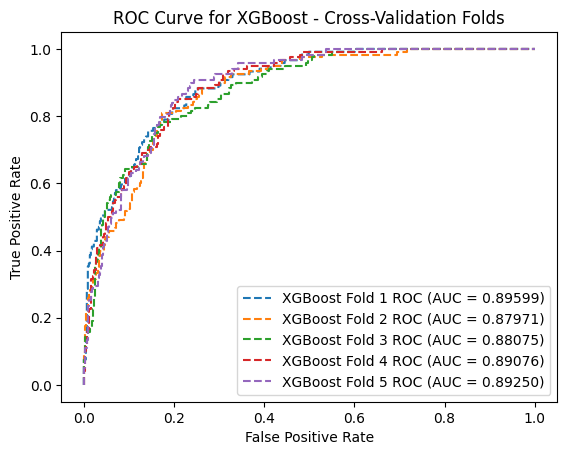

In [30]:
# Perform Stratified K-Fold Cross-Validation with the tuned XGBoost model
print("\nCross-Validation with Best XGBoost Model...")

best_xgb_model_smote = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    objective='binary:logistic',
    eval_metric='auc',
    subsample=0.6,
    reg_lambda=2,
    reg_alpha=0.01,
    n_estimators=200,
    min_child_weight=5,
    max_depth=7,
    learning_rate=0.01,
    gamma=0.3,
    colsample_bytree=0.8,
)

xgb_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Fit the best XGBoost model on this fold
    best_xgb_model_smote.fit(X_train_smote, y_train_smote)

    # Predict probabilities for validation set
    y_val_pred = best_xgb_model_smote.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    xgb_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'XGBoost Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nXGBoost Cross-Validation ROC AUC Scores: {xgb_cv_roc_scores}')
print(f'Mean ROC AUC Score for XGBoost: {np.mean(xgb_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## AdaBoost

### Hyperparameter Tuning

In [52]:
def tune_adaboost_params_smote():
    # Define AdaBoost model with initial parameters
    adaboost_model = AdaBoostClassifier(
        random_state=42
    )

    # Define the parameter grid for RandomizedSearchCV
    param_grid = {
        'clf__n_estimators': [50, 100, 200, 300, 400],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
        'clf__algorithm': ['SAMME', 'SAMME.R']
    }

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),  # Apply SMOTE on training data
        ('clf', adaboost_model)
    ])

    # RandomizedSearchCV for AdaBoost
    random_search_adaboost = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=20,  # Number of random combinations to try
        scoring='roc_auc',
        cv=skf,
        verbose=False,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )

    # Fit RandomizedSearchCV
    print("Starting RandomizedSearchCV...")
    random_search_adaboost.fit(X, y)
    print("RandomizedSearchCV complete.")

    # Best parameters and best score
    best_adaboost_model = random_search_adaboost.best_estimator_
    print(f"Best Parameters for AdaBoost: {random_search_adaboost.best_params_}")
    print(f"Best ROC-AUC Score from RandomizedSearchCV: {random_search_adaboost.best_score_}")

# Uncomment to run
# tune_adaboost_params_smote()

Starting RandomizedSearchCV...
RandomizedSearchCV complete.
Best Parameters for AdaBoost: {'clf__n_estimators': 200, 'clf__learning_rate': 0.05, 'clf__algorithm': 'SAMME.R'}
Best ROC-AUC Score from RandomizedSearchCV: 0.8845558820688633


Best Parameters for AdaBoost: {'clf__n_estimators': 200, 'clf__learning_rate': 0.05, 'clf__algorithm': 'SAMME.R'}

Best ROC-AUC Score from RandomizedSearchCV: 0.8845558820688633

### Best Model


Cross-Validation with Best AdaBoost Model...

AdaBoost Cross-Validation ROC AUC Scores: [0.8809586195279894, 0.8809151785714286, 0.8782738095238096, 0.8835565476190477, 0.8990752551020409]
Mean ROC AUC Score for AdaBoost: 0.8845558820688633


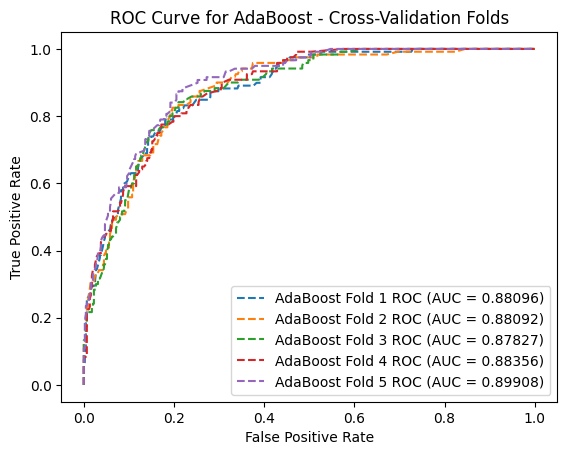

In [31]:
# Perform Stratified K-Fold Cross-Validation with the tuned AdaBoost model
print("\nCross-Validation with Best AdaBoost Model...")

best_adaboost_model_smote = AdaBoostClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    algorithm='SAMME.R'
)

adaboost_cv_roc_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Fit the best AdaBoost model on this fold
    best_adaboost_model_smote.fit(X_train_smote, y_train_smote)

    # Predict probabilities for validation set
    y_val_pred = best_adaboost_model_smote.predict_proba(X_val)[:, 1]

    # Calculate ROC-AUC score for this fold
    roc_auc = roc_auc_score(y_val, y_val_pred)
    adaboost_cv_roc_scores.append(roc_auc)

    # Plot ROC curve for each fold
    fpr, tpr, _ = roc_curve(y_val, y_val_pred)
    plt.plot(fpr, tpr, linestyle='--', label=f'AdaBoost Fold {fold+1} ROC (AUC = {roc_auc:.5f})')

# Display Cross-Validation Results
print(f'\nAdaBoost Cross-Validation ROC AUC Scores: {adaboost_cv_roc_scores}')
print(f'Mean ROC AUC Score for AdaBoost: {np.mean(adaboost_cv_roc_scores)}')

# Plot combined ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost - Cross-Validation Folds')
plt.legend(loc="lower right")
plt.show()

## Neural Network

### Model Training

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6282 - loss: 0.6427 - val_accuracy: 0.7799 - val_loss: 0.4690
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8124 - loss: 0.4332 - val_accuracy: 0.7729 - val_loss: 0.4445
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8296 - loss: 0.3843 - val_accuracy: 0.7570 - val_loss: 0.4600
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8529 - loss: 0.3431 - val_accuracy: 0.7553 - val_loss: 0.4761
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8559 - loss: 0.3466 - val_accuracy: 0.7852 - val_loss: 0.4245
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8523 - loss: 0.3268 - val_accuracy: 0.8151 - val_loss: 0.3822
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.3299 - val_accuracy: 0.7694 - val_loss: 0.4742
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8812 - loss: 0.2935 - val_accuracy: 0.

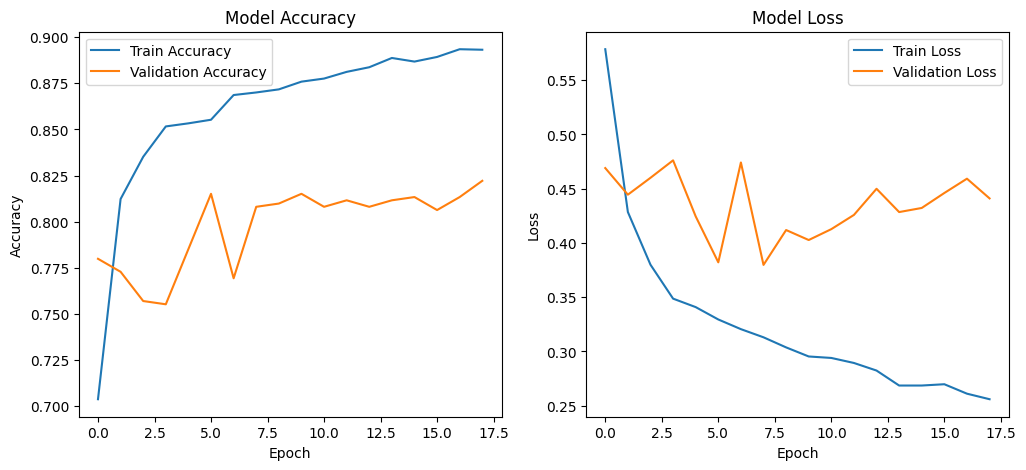

In [39]:
# Split data into training and validation sets (use stratified split for class balance)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build the neural network model
def build_nn_model_smote():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_smote.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
nn_model_smote = build_nn_model_smote()

# Train the model
history = nn_model_smote.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val, y_val),
    epochs=50,  # Can adjust based on performance
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on validation data
val_preds = nn_model_smote.predict(X_val).flatten()
val_auc = roc_auc_score(y_val, val_preds)
print(f"Validation ROC-AUC Score: {val_auc:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_val, val_preds)
plt.plot(fpr, tpr, linestyle='--', label=f'ROC (AUC = {roc_auc:.5f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network - Validation')
plt.legend(loc="lower right")
plt.show()

# Prediction - SMOTE

In [40]:
# Make predictions using Logistic Regression
y_test_pred_log_reg_smote = best_log_reg_clf_smote.predict(X_test)
y_test_pred_log_reg_proba_smote = best_log_reg_clf_smote.predict_proba(X_test)[:, 1]

# Make predictions using the best-tuned model (Random Forest)
y_test_pred_rf_smote = best_rf_clf_smote.predict(X_test)
y_test_pred_rf_proba_smote = best_rf_clf_smote.predict_proba(X_test)[:, 1]

# Make predictions using Gradient Boosting Classifier
y_test_pred_gbc_smote = best_gbc_clf_smote.predict(X_test)
y_test_pred_gbc_proba_smote = best_gbc_clf_smote.predict_proba(X_test)[:, 1]

# Make predictions using LightGBM model
y_test_pred_lgbm_smote = best_lgbm_model_smote.predict(X_test)
y_test_pred_lgbm_proba_smote = best_lgbm_model_smote.predict_proba(X_test)[:, 1]

# Make predictions using XGBoost model
y_test_pred_xgb_smote = best_xgb_model_smote.predict(X_test)
y_test_pred_xgb_proba_smote = best_xgb_model_smote.predict_proba(X_test)[:, 1]

# Make predictions using AdaBoost model
y_test_pred_adaboost_smote = best_adaboost_model_smote.predict(X_test)
y_test_pred_adaboost_proba_smote = best_adaboost_model_smote.predict_proba(X_test)[:, 1]

# Make predictions using Neural Network
y_test_pred_nn_smote = nn_model_smote.predict(X_test).flatten()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# Evaluation - SMOTE


--- Logistic Regression ---
Logistic Regression ROC-AUC (Test Data): 0.8940051843506984
Confusion Matrix (Test Data - Logistic Regression):
[[423 118]
 [ 32 137]]
Classification Report (Test Data - Logistic Regression):
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       541
           1       0.54      0.81      0.65       169

    accuracy                           0.79       710
   macro avg       0.73      0.80      0.75       710
weighted avg       0.84      0.79      0.80       710


--- Tuned Random Forest ---
Tuned Random Forest ROC-AUC (Test Data): 0.9019403034048278
Confusion Matrix (Test Data - Tuned Random Forest):
[[449  92]
 [ 37 132]]
Classification Report (Test Data - Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       541
           1       0.59      0.78      0.67       169

    accuracy                           0.82       710
   macro avg 

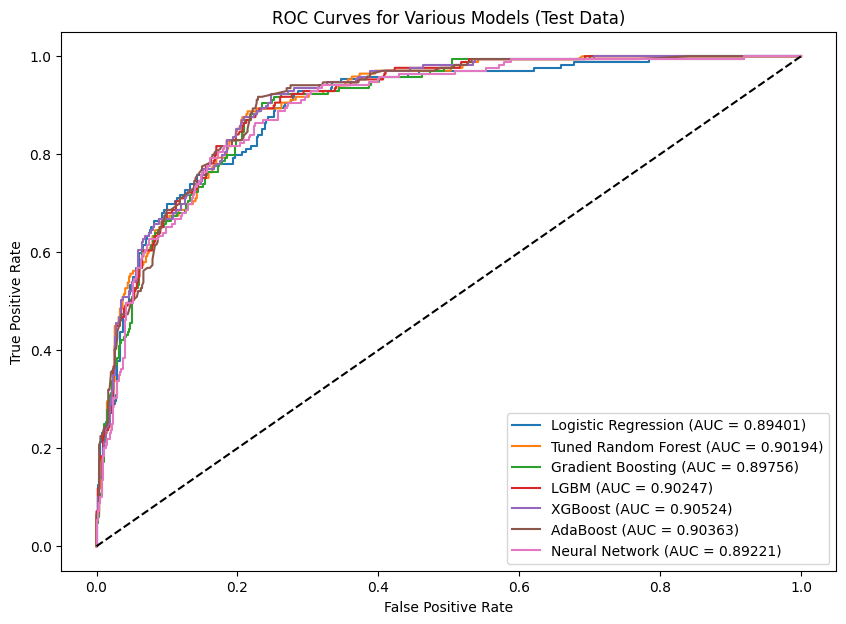

In [41]:
# 1. Logistic Regression Evaluation
print("\n--- Logistic Regression ---")
log_reg_roc_auc = roc_auc_score(y_test, y_test_pred_log_reg_proba_smote)
print(f"Logistic Regression ROC-AUC (Test Data): {log_reg_roc_auc}")

print("Confusion Matrix (Test Data - Logistic Regression):")
print(confusion_matrix(y_test, y_test_pred_log_reg_smote))

print("Classification Report (Test Data - Logistic Regression):")
print(classification_report(y_test, y_test_pred_log_reg_smote))

# 2. Tuned Random Forest Evaluation
print("\n--- Tuned Random Forest ---")
rf_roc_auc = roc_auc_score(y_test, y_test_pred_rf_proba_smote)  # y_test_pred_proba from best_rf model
print(f"Tuned Random Forest ROC-AUC (Test Data): {rf_roc_auc}")

print("Confusion Matrix (Test Data - Tuned Random Forest):")
print(confusion_matrix(y_test, y_test_pred_rf_smote))

print("Classification Report (Test Data - Tuned Random Forest):")
print(classification_report(y_test, y_test_pred_rf_smote))

# 3. Gradient Boosting Classifier Evaluation
print("\n--- Gradient Boosting Classifier ---")
gbc_roc_auc = roc_auc_score(y_test, y_test_pred_gbc_proba_smote)
print(f"Gradient Boosting Classifier ROC-AUC (Test Data): {gbc_roc_auc}")

print("Confusion Matrix (Test Data - Gradient Boosting Classifier):")
print(confusion_matrix(y_test, y_test_pred_gbc_smote))

print("Classification Report (Test Data - Gradient Boosting Classifier):")
print(classification_report(y_test, y_test_pred_gbc_smote))

# 4. Light Gradient Boosting Machine Model Evaluation
print("\n--- LGBM Model ---")
lgbm_roc_auc = roc_auc_score(y_test, y_test_pred_lgbm_proba_smote)
print(f"LGBM Model ROC-AUC (Test Data): {lgbm_roc_auc}")

print("Confusion Matrix (Test Data - LGBM Model):")
print(confusion_matrix(y_test, y_test_pred_lgbm_smote))

print("Classification Report (Test Data - LGBM Model):")
print(classification_report(y_test, y_test_pred_lgbm_smote))

# 5. eXtreme Gradient Boosting Model Evaluation
print("\n--- XGBoost Model ---")
xgb_roc_auc = roc_auc_score(y_test, y_test_pred_xgb_proba_smote)
print(f"XGBoost Model ROC-AUC (Test Data): {xgb_roc_auc}")

print("Confusion Matrix (Test Data - XGBoost Model):")
print(confusion_matrix(y_test, y_test_pred_xgb_smote))

print("Classification Report (Test Data - XGBoost):")
print(classification_report(y_test, y_test_pred_xgb_smote))

# 6. Adaptive Boosting Model Evaluation
print("\n--- AdaBoost Model ---")
adaboost_roc_auc = roc_auc_score(y_test, y_test_pred_adaboost_proba_smote)
print(f"AdaBoost Model ROC-AUC (Test Data): {adaboost_roc_auc}")

print("Confusion Matrix (Test Data - AdaBoost Model):")
print(confusion_matrix(y_test, y_test_pred_adaboost_smote))

print("Classification Report (Test Data - AdaBoost):")
print(classification_report(y_test, y_test_pred_adaboost_smote))

# 7. Neural Network Evaluation
print("\n--- Neural Network Model ---")
nn_roc_auc = roc_auc_score(y_test, y_test_pred_nn_smote)
print(f"Neural Network ROC-AUC (Test Data): {nn_roc_auc}")

print("Confusion Matrix (Test Data - Neural Network Model):")
print(confusion_matrix(y_test, (y_test_pred_nn_smote > 0.5).astype(int)))

print("Classification Report (Test Data - Neural Network):")
print(classification_report(y_test, (y_test_pred_nn_smote > 0.5).astype(int)))

# Plot ROC Curves for all models
fpr_log, tpr_log, _ = roc_curve(y_test, y_test_pred_log_reg_proba_smote)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_pred_rf_proba_smote)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_test_pred_gbc_proba_smote)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_test_pred_lgbm_proba_smote)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_xgb_proba_smote)
fpr_adaboost, tpr_adaboost, _ = roc_curve(y_test, y_test_pred_adaboost_proba_smote)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_test_pred_nn_smote)

plt.figure(figsize=(10, 7))

# Logistic Regression ROC curve
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {log_reg_roc_auc:.5f})')

# Tuned Random Forest ROC curve
plt.plot(fpr_rf, tpr_rf, label=f'Tuned Random Forest (AUC = {rf_roc_auc:.5f})')

# Gradient Boosting ROC curve
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {gbc_roc_auc:.5f})')

# LGBM ROC curve
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LGBM (AUC = {lgbm_roc_auc:.5f})')

# XGBoost ROC curve
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_roc_auc:.5f})')

# AdaBoost ROC curve
plt.plot(fpr_adaboost, tpr_adaboost, label=f'AdaBoost (AUC = {adaboost_roc_auc:.5f})')

# Neural Network ROC curve
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_roc_auc:.5f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models (Test Data)')
plt.legend()
plt.show()

# Summary of Performance - SMOTE

In [42]:
# Calculate evaluation metrics for each model
# (y_test_pred_nn > 0.5).astype(int)
evaluation_metrics = {
    "Model": ["Logistic Regression", "Tuned Random Forest", "Gradient Boosting", "LGBM", "XGBoost", "AdaBoost", "Neural Network"],
    "ROC-AUC": [
        round(roc_auc_score(y_test, y_test_pred_log_reg_proba_smote), 3),
        round(roc_auc_score(y_test, y_test_pred_rf_proba_smote), 3),
        round(roc_auc_score(y_test, y_test_pred_gbc_proba_smote), 3),
        round(roc_auc_score(y_test, y_test_pred_lgbm_proba_smote), 3),
        round(roc_auc_score(y_test, y_test_pred_xgb_proba_smote), 3),
        round(roc_auc_score(y_test, y_test_pred_adaboost_proba_smote), 3),
        round(roc_auc_score(y_test, y_test_pred_nn_smote), 3)
    ],
    "Accuracy (%)": [
        round(accuracy_score(y_test, y_test_pred_log_reg_smote) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_rf_smote) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_gbc_smote) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_lgbm_smote) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_xgb_smote) * 100, 3),
        round(accuracy_score(y_test, y_test_pred_adaboost_smote) * 100, 3),
        round(accuracy_score(y_test, (y_test_pred_nn_smote > 0.5).astype(int)) * 100, 3)
    ],
    "Precision (%)": [
        round(precision_score(y_test, y_test_pred_log_reg_smote) * 100, 3),
        round(precision_score(y_test, y_test_pred_rf_smote) * 100, 3),
        round(precision_score(y_test, y_test_pred_gbc_smote) * 100, 3),
        round(precision_score(y_test, y_test_pred_lgbm_smote) * 100, 3),
        round(precision_score(y_test, y_test_pred_xgb_smote) * 100, 3),
        round(precision_score(y_test, y_test_pred_adaboost_smote) * 100, 3),
        round(precision_score(y_test, (y_test_pred_nn_smote > 0.5).astype(int)) * 100, 3)
    ],
    "Recall (%)": [
        round(recall_score(y_test, y_test_pred_log_reg_smote) * 100, 3),
        round(recall_score(y_test, y_test_pred_rf_smote) * 100, 3),
        round(recall_score(y_test, y_test_pred_gbc_smote) * 100, 3),
        round(recall_score(y_test, y_test_pred_lgbm_smote) * 100, 3),
        round(recall_score(y_test, y_test_pred_xgb_smote) * 100, 3),
        round(recall_score(y_test, y_test_pred_adaboost_smote) * 100, 3),
        round(recall_score(y_test, (y_test_pred_nn_smote > 0.5).astype(int)) * 100, 3)
    ],
    "F1 Score": [
        round(f1_score(y_test, y_test_pred_log_reg_smote), 3),
        round(f1_score(y_test, y_test_pred_rf_smote), 3),
        round(f1_score(y_test, y_test_pred_gbc_smote), 3),
        round(f1_score(y_test, y_test_pred_lgbm_smote), 3),
        round(f1_score(y_test, y_test_pred_xgb_smote), 3),
        round(f1_score(y_test, y_test_pred_adaboost_smote), 3),
        round(f1_score(y_test, (y_test_pred_nn_smote > 0.5).astype(int)), 3)
    ]
}

# Convert to DataFrame for easy viewing
metrics_df = pd.DataFrame(evaluation_metrics)

# Convert DataFrame to tabulate format
print(tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False))


+---------------------+---------+--------------+---------------+------------+----------+
|        Model        | ROC-AUC | Accuracy (%) | Precision (%) | Recall (%) | F1 Score |
+---------------------+---------+--------------+---------------+------------+----------+
| Logistic Regression |  0.894  |    78.873    |    53.725     |   81.065   |  0.646   |
| Tuned Random Forest |  0.902  |    81.831    |    58.929     |   78.107   |  0.672   |
|  Gradient Boosting  |  0.898  |    82.958    |     62.5      |   71.006   |  0.665   |
|        LGBM         |  0.902  |    82.535    |    60.369     |   77.515   |  0.679   |
|       XGBoost       |  0.905  |    82.535    |    60.976     |   73.964   |  0.668   |
|      AdaBoost       |  0.904  |    80.845    |     56.68     |   82.84    |  0.673   |
|   Neural Network    |  0.892  |    82.676    |     62.5      |   68.047   |  0.652   |
+---------------------+---------+--------------+---------------+------------+----------+
